In [7]:
%load_ext autoreload
%env TFDS_DATA_DIR=/Users/paul/datasets/tensorflow_datasets
%env PYTHONPATH=../

import sys
sys.path.append("../")

import os
print(os.environ["PYTHONPATH"])

import numpy as np
from tensorflow import keras
from oodeel.methods import MLS, DKNN, ODIN
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import DataHandler

from sklearn.metrics import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TFDS_DATA_DIR=/Users/paul/datasets/tensorflow_datasets
env: PYTHONPATH=../
../


## Two datasets experiment

In [2]:
%autoreload 2

def normalize(x):
    return x/255
    
data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]
x_train = ds1["train"]

x_test = data_handler.merge_tfds(x_id, x_ood, shuffle=False)

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 64.00 GB
maxCacheSize: 3.99 GB



2022-12-19 14:53:08.084406: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:

model = tf.keras.models.load_model("../saved_models/mnist_model")

### MLS

{'auroc': 0.9942104999999999, 'fpr95tpr': 0.023, 'accuracy_score': 0.9675, 'roc_auc_score': 0.9942005}


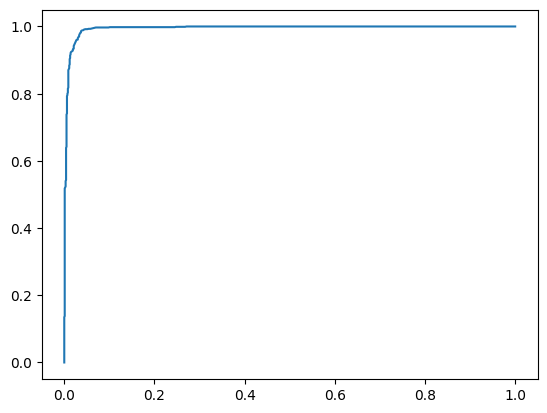

In [9]:

%autoreload 2


oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)

metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()


### DKNN

2022-12-19 10:42:34.686173: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'auroc': 0.8568145, 'fpr95tpr': 0.498, 'accuracy_score': 0.5, 'roc_auc_score': 0.8568170000000002}


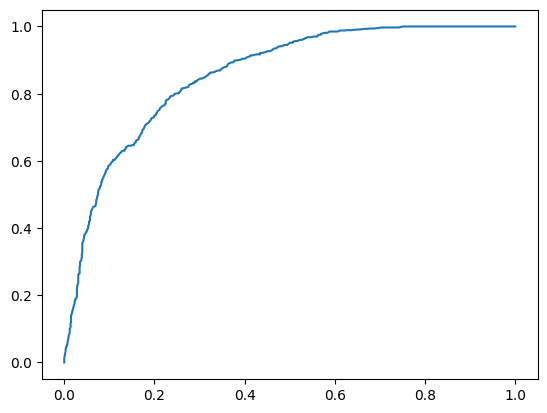

In [8]:
%autoreload 2

## This time need a dataset to fit KNN score
x_test = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000))

oodmodel = DKNN()
oodmodel.fit(model, x_train.take(10000))
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

{'auroc': 0.991816835, 'fpr95tpr': 0.0361, 'accuracy_score': 0.5, 'roc_auc_score': 0.9918168650000001}


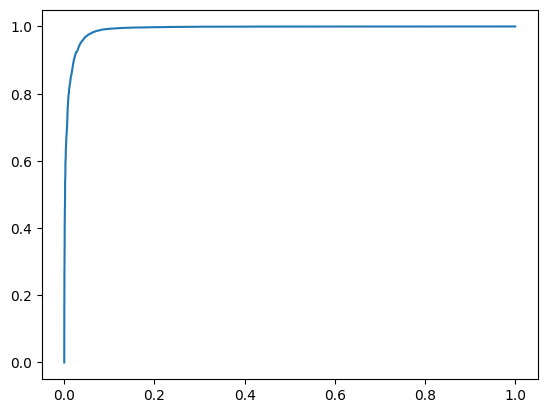

In [7]:

%autoreload 2
from oodeel.methods import ODIN

x_test = data_handler.merge_tfds(x_id, x_ood)
labels = data_handler.get_ood_labels(x_test)


oodmodel = ODIN()
oodmodel.fit(model)
scores_id = oodmodel.score(x_id)
scores_ood = oodmodel.score(x_ood)

scores = np.append(scores_id, scores_ood)
#labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [3]:
%autoreload 2
inc_labels = [0, 1, 2, 3, 4]
data_handler = DataHandler()
ds = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
x_id, x_ood = data_handler.filter_tfds(ds["test"], inc_labels = inc_labels )
x_train_id, _ = data_handler.filter_tfds(ds["train"], inc_labels = inc_labels )

In [4]:
%autoreload 2
from oodeel.models.training_funs import train_convnet

train_config = {
    "batch_size": 128,
    "epochs": 5
}

model = train_convnet(x_train_id, **train_config)

Epoch 1/5
240/240 [==============================] - 9s 29ms/step - loss: 0.2245 - accuracy: 0.9329
Epoch 2/5
240/240 [==============================] - 6s 24ms/step - loss: 0.0443 - accuracy: 0.9863
Epoch 3/5
240/240 [==============================] - 6s 26ms/step - loss: 0.0259 - accuracy: 0.9929
Epoch 4/5
240/240 [==============================] - 6s 25ms/step - loss: 0.0166 - accuracy: 0.9958
Epoch 5/5
240/240 [==============================] - 6s 23ms/step - loss: 0.0106 - accuracy: 0.9975


## MLS

{'auroc': 0.9539497705406648, 'fpr95tpr': 0.2268923915158591, 'accuracy_score': 0.8791, 'roc_auc_score': 0.953947608870039}


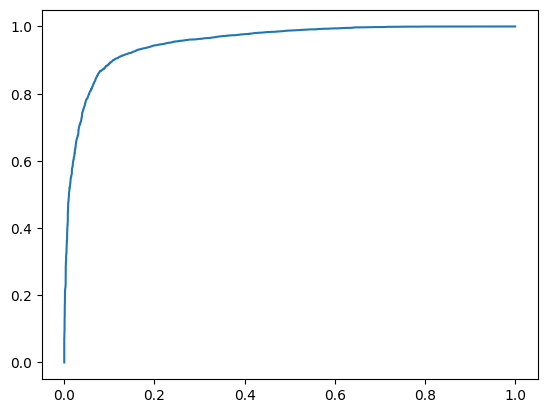

In [5]:
%autoreload 2


x_test = data_handler.merge_tfds(x_id, x_ood, shuffle=False)

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### DKNN

{'auroc': 0.9366304999999999, 'fpr95tpr': 0.33, 'accuracy_score': 0.5, 'roc_auc_score': 0.936625}


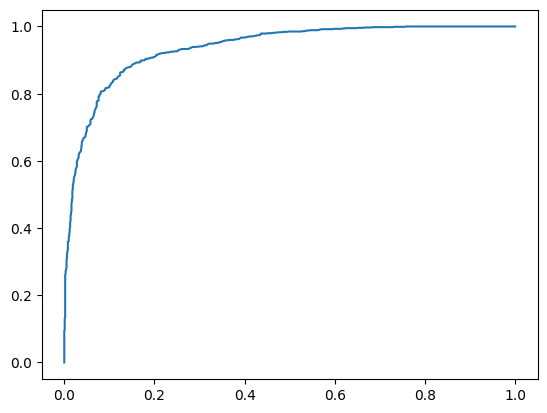

In [13]:
%autoreload 2

x_test = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000))

oodmodel = DKNN()
oodmodel.fit(model, x_train_id.take(10000))
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

Cause: could not parse the source code of <function ODIN._tfds_input_perturbation.<locals>.<lambda> at 0x18fff10d0>: no matching AST found among candidates:
# coding=utf-8
lambda x: self._input_perturbation(x, num_classes)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function ODIN._tfds_input_perturbation.<locals>.<lambda> at 0x18fff10d0>: no matching AST found among candidates:
# coding=utf-8
lambda x: self._input_perturbation(x, num_classes)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function ODIN._tfds_input_perturbation.<locals>.<lambda> at 0x18fff10d0>: no matching AST found among candidates:
# coding=utf-8
lambda x: self._input_perturbation(x, num_classes)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
{'auroc': 0.9292604096149669, 'fpr95tpr': 0.4092235843549329, 'accuracy_score': 0.4861, 'roc_auc_score': 0.9292584681144975}


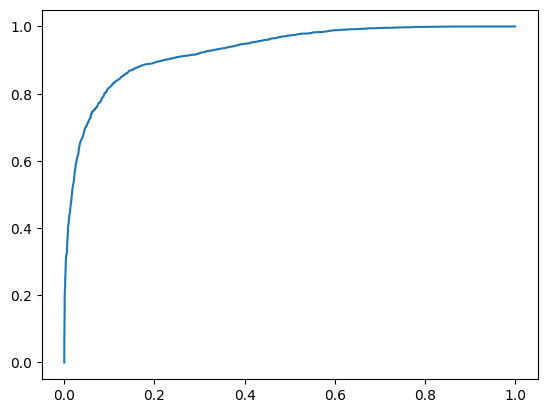

In [10]:
%autoreload 2


x_test = data_handler.merge_tfds(x_id, x_ood, shuffle=False)
#x_test, y_id = data_handler.convert_to_numpy(x_id)

oodmodel = ODIN()
oodmodel.fit(model)
scores = oodmodel.score(x_test)
labels = data_handler.get_ood_labels(x_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()